In [1]:
import pandas as pd
import numpy as np
import math
from concurrent.futures import ThreadPoolExecutor
import time
from scipy.sparse import csr_matrix, csc_matrix
import matplotlib.pyplot as plt
from collections import defaultdict

In [16]:
# 分位图草图
class WeightedQuantileSketch:
    def __init__(self, eps=0.05, max_size=100):
        self.eps = eps
        self.max_size = max_size
        self.summaries = defaultdict(list)
    
    def _compute_rank(self, values, weights, epsilon):
        total_weight = weights.sum()
        target = epsilon * total_weight
        current_weight = 0.0
        candidates = []
        sorted_idx = np.argsort(values)
        sorted_values = values[sorted_idx]
        sorted_weights = weights[sorted_idx]
        
        for v, w in zip(sorted_values, sorted_weights):
            current_weight += w
            if current_weight >= target:
                candidates.append(v)
                current_weight = 0.0
        return np.array(candidates)
    
    def create_summary(self, feature_idx, values, hessians):
        candidates = self._compute_rank(values, hessians, self.eps)
        self.summaries[feature_idx] = candidates
    
    def get_candidates(self, feature_idx):
        return self.summaries.get(feature_idx, [])

In [52]:
# 压缩列存储块结构CSC
class ColumnBlock:
    def __init__(self, data, feature_idx, sample_indices):
        self.feature_idx = feature_idx
        self.sample_indices = sample_indices  # 当前节点的样本索引（指向原始数据）
        self.data = data[self.sample_indices, feature_idx].astype(np.float32)
        self.sorted_idx = np.argsort(self.data)  # 对当前子集排序的局部索引（0到len(sample_indices)-1）
        self.sorted_values = self.data[self.sorted_idx]
        self.missing_mask = np.isnan(self.sorted_values)
        self.valid_idx = np.where(~self.missing_mask)[0]
        
    def get_non_missing(self):
        return self.sorted_values[self.valid_idx], self.sorted_idx[self.valid_idx]

In [59]:
# 生成单个树，包括方法：
# 1.Exact Split Finding
# 2.Approximate Split Finding
# 3.Sparse Split Finding
# 4.并行多线程处理
class BoostTreeNode:
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None, default_left=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.default_left = default_left
        self.best_gain = 0.0

class BoosterTree:
    def __init__(self, params, n_threads=1):  # 修改构造函数，移除column_blocks
        self.root = None
        self.max_depth = params.get('max_depth', 5)
        self.reg_lambda = params.get('reg_lambda', 1.0)
        self.gamma = params.get('gamma', 0.0)
        self.min_child_weight = params.get('min_child_weight', 1.0)
        self.colsample_bynode = params.get('colsample_bynode', 1.0)
        self.method = params.get('method', 'exact')  # 'exact' or 'approx'
        self.sparse = params.get('sparse', False)  # New parameter for sparsity awareness
        self.n_threads = n_threads
        self.column_blocks = None  # 在fit时初始化
        self.X = None  # 新增：保存原始数据引用
        self.grad_stats = None  # 新增：保存全局梯度/hessian
        self.quantile_sketch = WeightedQuantileSketch(eps=0.05) if self.method == 'approx' else None

    def fit(self, X, grad_stats, indices=None):
        if indices is None:
            indices = np.arange(len(grad_stats))
        self.X = X
        self.grad_stats = grad_stats  # 全局梯度/hessian
        self.n_samples, self.n_features = len(indices), X.shape[1]
        
        if self.method == 'approx':
            self.non_missing_masks = []
            X_subset = X[indices]
            h = self.grad_stats[indices, 1]
            for fidx in range(self.n_features):
                feature_values = X_subset[:, fidx]
                non_missing_mask = ~np.isnan(feature_values)
                self.non_missing_masks.append(non_missing_mask)
                values = feature_values[non_missing_mask]
                h_non_missing = h[non_missing_mask]
                if len(values) > 0:
                    self.quantile_sketch.create_summary(fidx, values, h_non_missing)
        
        self.root = self._grow_tree(indices, depth=0)  # 使用子样本数据
    
    def _grow_tree(self, sample_indices, depth=0):
        g = self.grad_stats[sample_indices, 0]  # 通过索引获取当前节点的梯度/hessian
        h = self.grad_stats[sample_indices, 1]
        node_value = -g.sum() / (h.sum() + self.reg_lambda)
        node = BoostTreeNode(value=node_value)
        
        if depth >= self.max_depth or len(sample_indices) < 2:
            return node
        
        column_blocks = [ColumnBlock(self.X, fidx, sample_indices) for fidx in range(self.n_features)]
        feature_indices = self._get_feature_subset()
        
        if self.method == 'exact' and not self.sparse:
            best_gain, best_feature, best_threshold = self._find_split_exact(column_blocks, g, h, feature_indices)
            if best_gain <= 0.0:
                return node
            node.feature_idx, node.threshold, node.best_gain = best_feature, best_threshold, best_gain
            node.default_left = False
            feature_values = self.X[sample_indices, best_feature]
            left_mask = feature_values <= best_threshold
            right_mask = ~left_mask
        elif self.method == 'approx' and not self.sparse:
            best_gain, best_feature, best_threshold = self._find_split_approx(column_blocks, g, h, feature_indices)
            if best_gain <= 0.0:
                return node
            node.feature_idx, node.threshold, node.best_gain = best_feature, best_threshold, best_gain
            node.default_left = False
            feature_values = self.X[sample_indices, best_feature]
            left_mask = feature_values <= best_threshold
            right_mask = ~left_mask
        else:  # Sparse-aware (exact or approx)
            best_gain, best_feature, best_threshold, best_default_left = self._find_split_sparse(
                column_blocks, g, h, feature_indices, exact=(self.method == 'exact')
            )
            if best_gain <= 0.0:
                return node
            node.feature_idx, node.threshold, node.best_gain = best_feature, best_threshold, best_gain
            node.default_left = best_default_left
            feature_values = self.X[sample_indices, best_feature]
            miss_mask = np.isnan(feature_values)
            left_mask = ((feature_values <= best_threshold) & ~miss_mask) | (miss_mask & best_default_left)
            right_mask = ~left_mask
        
        node.left = self._grow_tree(sample_indices[left_mask], depth + 1)
        node.right = self._grow_tree(sample_indices[right_mask], depth + 1)
        return node

    def _get_feature_subset(self):
        n_selected = int(self.n_features * self.colsample_bynode)
        return np.random.choice(self.n_features, n_selected, replace=False)

    def _find_split_exact(self, column_blocks, g, h, feature_indices):
        total_g, total_h = g.sum(), h.sum()
        
        def process_feature(fidx):
            block = column_blocks[fidx]
            values, local_indices = block.sorted_values, block.sorted_idx
            
            g_cum = np.cumsum(g[local_indices])
            h_cum = np.cumsum(h[local_indices])
            valid = (h_cum >= self.min_child_weight) & ((total_h - h_cum) >= self.min_child_weight)
            valid_idx = np.where(valid)[0]
            if len(valid_idx) == 0:
                return 0.0, None, None
            
            gains = 0.5 * (
                g_cum[valid_idx]**2 / (h_cum[valid_idx] + self.reg_lambda) +
                (total_g - g_cum[valid_idx])**2 / (total_h - h_cum[valid_idx] + self.reg_lambda) -
                total_g**2 / (total_h + self.reg_lambda)
            ) - self.gamma
            best_idx = np.argmax(gains)
            best_gain = gains[best_idx]
            best_thresh = (values[valid_idx[best_idx]] + values[valid_idx[best_idx] + 1]) / 2
            return best_gain, fidx, best_thresh
        
        with ThreadPoolExecutor(self.n_threads) as executor:
            results = list(executor.map(process_feature, feature_indices))
        best_result = max(results, key=lambda x: x[0])
        return best_result[0], best_result[1], best_result[2]

    def _find_split_approx(self, column_blocks, g, h, feature_indices):
        total_g, total_h = g.sum(), h.sum()
        best_gain, best_feature, best_threshold = 0.0, None, None
        
        for fidx in feature_indices:
            block = column_blocks[fidx]
            values, local_indices = block.get_non_missing()
            if len(values) == 0:
                continue
                
            candidates = self.quantile_sketch.get_candidates(fidx)
            if len(candidates) == 0:
                continue
            
            for thresh in candidates:
                left_mask = (values <= thresh) & local_indices
                sum_g_left = g[local_indices[left_mask]].sum()  # indices是当前block的有效索引，对应于子样本
                sum_h_left = h[local_indices[left_mask]].sum()
                sum_g_right = total_g - sum_g_left
                sum_h_right = total_h - sum_h_left
                if sum_h_left < self.min_child_weight or sum_h_right < self.min_child_weight:
                    continue
                gain = 0.5 * (
                    sum_g_left**2 / (sum_h_left + self.reg_lambda) +
                    sum_g_right**2 / (sum_h_right + self.reg_lambda) -
                    total_g**2 / (total_h + self.reg_lambda)
                ) - self.gamma
                if gain > best_gain:
                    best_gain, best_feature, best_threshold = gain, fidx, thresh
        return best_gain, best_feature, best_threshold
    
    def _find_split_sparse(self, column_blocks, g, h, feature_indices, exact=True):
        total_g, total_h = g.sum(), h.sum()
        
        def process_feature(fidx):
            block = column_blocks[fidx]
            values, local_indices = block.get_non_missing()
            if len(values) == 0:
                return 0.0, None, None, None
            
            g_non_miss = g[local_indices]
            h_non_miss = h[local_indices]
            miss_mask = block.missing_mask
            miss_indices = block.sorted_idx[miss_mask]
            sum_g_miss = g[miss_indices].sum() if len(miss_indices) > 0 else 0.0
            sum_h_miss = h[miss_indices].sum() if len(miss_indices) > 0 else 0.0
            has_missing = (sum_g_miss != 0) or (sum_h_miss != 0)
            
            if exact:
                sorted_idx = np.argsort(values)
                g_sorted = g_non_miss[sorted_idx]
                h_sorted = h_non_miss[sorted_idx]
                values_sorted = values[sorted_idx]
                best_gain, best_threshold, best_default_left = 0.0, None, None
                sum_g_left, sum_h_left = 0.0, 0.0
                
                for i in range(1, len(values_sorted)):
                    sum_g_left += g_sorted[i-1]
                    sum_h_left += h_sorted[i-1]
                    sum_g_right = total_g - sum_g_left - sum_g_miss
                    sum_h_right = total_h - sum_h_left - sum_h_miss
                    if (values_sorted[i] == values_sorted[i-1] or
                        sum_h_left < self.min_child_weight or
                        sum_h_right < self.min_child_weight):
                        continue
                    
                    if has_missing:
                        # 处理两种情况：缺失值默认左或右
                        gain_left = 0.5 * (
                            (sum_g_left + sum_g_miss)**2 / (sum_h_left + sum_h_miss + self.reg_lambda) +
                            sum_g_right**2 / (sum_h_right + self.reg_lambda) -
                            total_g**2 / (total_h + self.reg_lambda)
                        ) - self.gamma
                        gain_right = 0.5 * (
                            sum_g_left**2 / (sum_h_left + self.reg_lambda) +
                            (sum_g_right + sum_g_miss)**2 / (sum_h_right + sum_h_miss + self.reg_lambda) -
                            total_g**2 / (total_h + self.reg_lambda)
                        ) - self.gamma
                        current_gain = max(gain_left, gain_right)
                        default_left = gain_left > gain_right
                    else:
                        # 无缺失值时，仅计算一次增益
                        current_gain = 0.5 * (
                            sum_g_left**2 / (sum_h_left + self.reg_lambda) +
                            sum_g_right**2 / (sum_h_right + self.reg_lambda) -
                            total_g**2 / (total_h + self.reg_lambda)
                        ) - self.gamma
                        default_left = False  # 无影响，可设为任意值

                    if current_gain > best_gain:
                        best_gain = current_gain
                        best_threshold = (values_sorted[i-1] + values_sorted[i]) / 2
                        best_default_left = default_left if has_missing else True
            else:
                candidates = self.quantile_sketch.get_candidates(fidx)
                best_gain, best_threshold, best_default_left = 0.0, None, None
                for thresh in candidates:
                    left_mask = (values <= thresh) & local_indices
                    sum_g_left = g_non_miss[left_mask].sum()
                    sum_h_left = h_non_miss[left_mask].sum()
                    sum_g_right = total_g - sum_g_left - sum_g_miss
                    sum_h_right = total_h - sum_h_left - sum_h_miss
                    if sum_h_left < self.min_child_weight or sum_h_right < self.min_child_weight:
                        continue
                    gain_left = 0.5 * (
                        (sum_g_left + sum_g_miss)**2 / (sum_h_left + sum_h_miss + self.reg_lambda) +
                        sum_g_right**2 / (sum_h_right + self.reg_lambda) -
                        total_g**2 / (total_h + self.reg_lambda)
                    ) - self.gamma
                    gain_right = 0.5 * (
                        sum_g_left**2 / (sum_h_left + self.reg_lambda) +
                        (sum_g_right + sum_g_miss)**2 / (sum_h_right + sum_h_miss + self.reg_lambda) -
                        total_g**2 / (total_h + self.reg_lambda)
                    ) - self.gamma
                    if gain_left > best_gain:
                        best_gain, best_threshold = gain_left, thresh
                        best_default_left = True
                    if gain_right > best_gain:
                        best_gain, best_threshold = gain_right, thresh
                        best_default_left = False
            return best_gain, fidx, best_threshold, best_default_left
        
        with ThreadPoolExecutor(self.n_threads) as executor:
            results = list(executor.map(process_feature, feature_indices))
        best_result = max(results, key=lambda x: x[0])
        return best_result[0], best_result[1], best_result[2], best_result[3]

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        return np.array([self._predict(x, self.root) for x in X])

    def _predict(self, x, node):
        if node.left is None and node.right is None:
            return node.value
        if np.isnan(x[node.feature_idx]):
            return self._predict(x, node.left if node.default_left else node.right)
        return self._predict(x, node.left if x[node.feature_idx] <= node.threshold else node.right)

In [54]:
# XGBoost模型
class XGBoostModel:
    def __init__(self, params=None, random_seed=None, n_threads=1):
        params = params or {}
        self.params = params
        self.base_value = params.get('base_value', 0.5)
        self.subsample = params.get('subsample', 1.0)
        self.learning_rate = params.get('learning_rate', 0.3)
        self.rng = np.random.default_rng(random_seed)
        self.boosters = []
        self.n_threads = n_threads
        self.column_blocks = None
        self.grad_stats = None
        self.avg_time_per_tree = None

    def fit(self, X, y, objective, rounds, verbose=False):
        if isinstance(X, (csr_matrix, csc_matrix)):
            X = X.toarray()
        y = np.asarray(y)
        preds = self.base_value * np.ones(shape=y.shape)
        self.grad_stats = np.empty((X.shape[0], 2))
        times = []

        for i in range(rounds):
            start_time = time.time()
            self.grad_stats[:, 0] = objective.gradient(y, preds)
            self.grad_stats[:, 1] = objective.hessian(y, preds)
            indices = self._get_subsample_indices(y) if self.subsample < 1.0 else None
            booster = BoosterTree(self.params, n_threads=self.n_threads)  # 移除column_blocks参数
            booster.fit(X, self.grad_stats, indices)
            preds += self.learning_rate * booster.predict(X)
            self.boosters.append(booster)
            end_time = time.time()
            times.append(end_time - start_time)
            if verbose:
                current_loss = objective.loss(y, preds)
                print(f"[{i}] Training Loss: {current_loss:.5f}")
        self.avg_time_per_tree = np.mean(times)

    def predict(self, X):
        if isinstance(X, (csr_matrix, csc_matrix)):
            X = X.toarray()
        adjustments = self.learning_rate * np.sum([t.predict(X) for t in self.boosters], axis=0)
        return self.base_value + adjustments

    def _get_subsample_indices(self, y):
        sample_size = math.floor(self.subsample * len(y))
        return self.rng.choice(len(y), size=sample_size, replace=False)

In [20]:
class SquaredErrorObjective:
    def loss(self, y, pred):
        return np.mean((y - pred)**2)
    def gradient(self, y, pred):
        return pred - y
    def hessian(self, y, pred):
        return np.ones(len(y))

In [7]:
from zipfile import ZipFile

def load_data(zip_name, file_name):
    with ZipFile(zip_name) as zf:
        with zf.open(file_name) as f:
            df = pd.read_csv(f, na_values='?')

    X = df.drop('Claim_Amount', axis=1) if file_name == 'train_set.csv' else df
    y = (df['Claim_Amount'] > 0.0).astype('float32') if file_name == 'train_set.csv' else None

    # 定义分类变量和连续变量列名
    cat_cols = ['Calendar_Year','Model_Year', 'Blind_Make', 'Blind_Model', 'Blind_Submodel', 
                'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 
                'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'NVCat']
    ord_cols = ['OrdCat']
    cont_cols = ['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 
                 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4']

    # 处理分类变量的缺失值并转换为字符串
    df[cat_cols] = df[cat_cols].fillna("__MISSING__").astype(str)
    
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from scipy.sparse import hstack

    # 分类变量: 独热编码，输出稀疏矩阵
    transformers = []
    for col in cat_cols:
        valid_categories = df[col].unique().reshape(-1, 1)
        encoder = OneHotEncoder(
            categories=[valid_categories.flatten()],
            handle_unknown="ignore",
            drop="first",
            sparse_output=True  # 改为 True，使用稀疏矩阵
        )
        transformers.append((f"encode_{col}", encoder, [col]))

    ct = ColumnTransformer(transformers, remainder="drop")
    X_cat_sparse = ct.fit_transform(df)
    
    # 连续变量: 均值填补
    imputer = SimpleImputer(strategy='mean')
    X_cont_filled = imputer.fit_transform(df[cont_cols])
    
    # 有序变量：替换'?'为0，并标准化
    X_ord = X[ord_cols].fillna(0.)
    scaler = StandardScaler()
    ord_cat_scaled = scaler.fit_transform(X_ord)
    X_ord_sparse = csr_matrix(X_ord)
    
    # 利用稀疏矩阵解决内存爆炸  
    X_cont_sparse = csr_matrix(X_cont_filled)
    X_processed_sparse = hstack([X_cat_sparse, X_ord_sparse, X_cont_sparse])

    # 分割出10K数据，m=4225，差俩ID数据
    if file_name == 'train_set.csv':
        X_train, X_val, y_train, y_val = train_test_split(X_processed_sparse, y, 
                                                          train_size=10000, 
                                                          random_state=42)
        return X_train, X_val, y_train, y_val
    else:
        return X_processed_sparse

In [8]:
zip_name = './dataset/train_set.zip'
file_name = 'train_set.csv'
X_train, X_val, y_train, y_val = load_data(zip_name, file_name)

[0] Training Loss: 0.12642
[1] Training Loss: 0.06567
[2] Training Loss: 0.03602
[3] Training Loss: 0.02144
[4] Training Loss: 0.01421
[0] Training Loss: 0.12642
[1] Training Loss: 0.06567
[2] Training Loss: 0.03602
[3] Training Loss: 0.02144
[4] Training Loss: 0.01421
[0] Training Loss: 0.12642
[1] Training Loss: 0.06567
[2] Training Loss: 0.03602
[3] Training Loss: 0.02144
[4] Training Loss: 0.01421
[0] Training Loss: 0.12642
[1] Training Loss: 0.06567
[2] Training Loss: 0.03602
[3] Training Loss: 0.02144
[4] Training Loss: 0.01421
[0] Training Loss: 0.12642
[1] Training Loss: 0.06567
[2] Training Loss: 0.03602
[3] Training Loss: 0.02144
[4] Training Loss: 0.01421
[0] Training Loss: 0.12642
[1] Training Loss: 0.06567
[2] Training Loss: 0.03602
[3] Training Loss: 0.02144
[4] Training Loss: 0.01421
[0] Training Loss: 0.12642
[1] Training Loss: 0.06567
[2] Training Loss: 0.03602
[3] Training Loss: 0.02144
[4] Training Loss: 0.01421
[0] Training Loss: 0.12642
[1] Training Loss: 0.06567
[

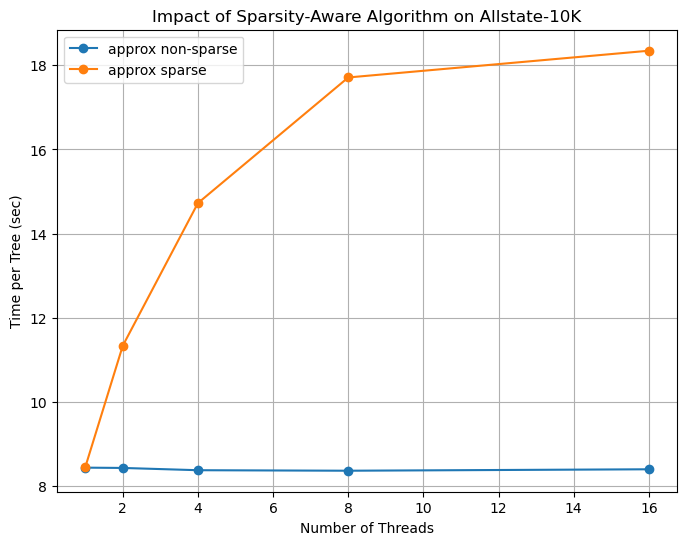

In [60]:
import matplotlib.pyplot as plt

# Objective
objective = SquaredErrorObjective()

# Parameters
params = {
    'max_depth': 5,
    'reg_lambda': 1.0,
    'gamma': 0.0,
    'min_child_weight': 1.0,
    'colsample_bynode': 0.6,
    'subsample': 0.6,
    'learning_rate':0.3,
    'base_value':0.5,
}
rounds = 5

# Experiment
n_threads_list = [1, 2, 4, 8, 16]  # 根据硬件调整
methods = [('approx', False), ('approx', True)]  # (method, sparse)
results = {f"{method}_{sparse}": [] for method, sparse in methods}

for method, sparse in methods:
    for n_threads in n_threads_list:
        params['method'] = method
        params['sparse'] = sparse
        model = XGBoostModel(params, random_seed=42, n_threads=n_threads)
        model.fit(X_train, y_train, objective, rounds, verbose=True)
        results[f"{method}_{sparse}"].append(model.avg_time_per_tree)

# Plotting
plt.figure(figsize=(8, 6))
for method, sparse in methods:
    label = f"{method} {'sparse' if sparse else 'non-sparse'}"
    plt.plot(n_threads_list, results[f"{method}_{sparse}"], marker='o', label=label)
plt.xlabel('Number of Threads')
plt.ylabel('Time per Tree (sec)')
plt.title('Impact of Sparsity-Aware Algorithm on Allstate-10K')
plt.legend()
plt.grid(True)
plt.show()